# osNMF tutorial

This notebook runs the core analyses for osNMF. Source code: https://github.com/abbasilab/osNMF


**Outline:**
1. Impute missing values using k-nearest neighbors (kNN)
2. Generate PPs using stability-driven non-negative matrix factorization
3. Stability analysis to identify the most stable number of PPs
4. 3D visualization of PPs
5. Spatial coherence using Moran's Index
6. Identifying putative marker genes from PPs
7. Identify putative local gene interaction networks for each PP 

**Note on data:**
The primary dataset used in this study is the in situ hybridization (ISH) measurements from 4,345 genes at 200 µm isotropic resolution from the adult mouse brain at 56 days postnatal [13]. The data was collected at the Allen Institute for Brain Science and is publicly available under the Allen Brain Atlas (ABA) [https://mouse.brain-map.org/]. The methods for data collection are described in detail in [13]. An API enables the download of the data at [http://help.brain-map.org/display/mousebrain/API]. The Allen Mouse Brain Common Coordinate Framework (CCF) was used as the 3D reference atlas [46]. We used CCFv3 which is publicly available at [http://help.brain-map.org/display/mousebrain/api]. CCF consists of parcellations of the entire mouse brain in 3D and at 10 μm voxel resolution. CCF provides labeling for every voxel with a brain structure spanning 43 isocortical areas and their layers, 329 subcortical gray matter structures, 81 fiber tracts, and 8 ventricular structures. The methods for constructing the CCF dataset are described in detail in [46]. 

In [1]:
# import public libraries
import matplotlib.pyplot as plt
import napari
import nrrd
import numpy as np
import os
import pandas as pd
import pickle
from scipy import stats
from scipy.optimize import linear_sum_assignment
from scipy.optimize import nnls
import sklearn.preprocessing

# import functions from osNMF code (https://github.com/abbasilab/osNMF)
from knn_impute import kNN_imputation
from morans_index import MoranIforPPs
from pca_with_missing_values import pca_with_missing_values
from other_functions import show_graph_with_labels, filter_genes, weighted_correlation
from sklearn_nmf import sklearn_nmf
from stability import findcorrelation, HungarianError, amariMaxError, instability

## 1. kNN imputation of missing values

In [2]:
# # Commented out: takes ~20 mins to run on 2021 MacBook Pro

# #load original input data
# tmp = np.load('../data/mouse_brain_ISH_float32.npz',allow_pickle=True)
# data = tmp['data']
# sections = tmp['sections'].tolist()
# original_shape = data.shape
# original_shape

# # preprocess find the high missing rate region
# all_missed = (np.mean(data < 0, axis=0) >= .95)
# selected = np.logical_not(all_missed)[np.newaxis, :, :, :]

# # fit_model
# knn_model = kNN_imputation(n_neighbors=6, weights='distance')
# imputed = knn_model.fit_transform(data, selected[0], inplace=True)

# # save data
# np.savez("../data/imputed_data_kNN_neighbor_6_weights_distance.npz",
#          imputed=imputed, selected=selected)

## 2. run NMF model to generate 11 PPs
This is to illustrate how the model is run. Later, we run stability analysis on a variety of values for the number of PPs (K) to determine that 11 is the most stable congfiguration.

In [3]:
# load kNN imputed data
tmp = np.load('../data/imputed_data_kNN_neighbor_6_weights_distance.npz')
data = tmp['imputed']
selected = tmp['selected']
original_shape = data.shape

#load reference atlas from Allen Institute for Brain Science, CCF
areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('../data/mouse_coarse_df')

data.shape

(4345, 67, 41, 58)

In [4]:
# preprocessing

# compute the support
support = np.sum(areas_atlas, 0) > 0

# get the data within the reference atlas
filtered_data = data[:,:-1,:-1,:-1][:, support]
filtered_data.shape

(4345, 55954)

In [5]:
# Create 11 PPs and coefficients using NMF
# Note: Stability analysis (shown below) identified 11 PPs as most stable

nmf = sklearn_nmf(n_components=11, l1_ratio=1, alpha = 0, random_state=1)
nmf.fit(np.maximum(filtered_data,0)) # fit model

# Create PPs and coeffs
PPs = nmf.components_
coeffs = nmf.transform(np.maximum(filtered_data,0))

# preprocess unmask
PPs_3d = np.zeros((len(PPs), 66, 40, 57))
PPs_3d[:,support] = PPs * (PPs > 0.05)
print(PPs_3d.shape, PPs.shape, coeffs.shape)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


(11, 66, 40, 57) (11, 55954) (4345, 11)


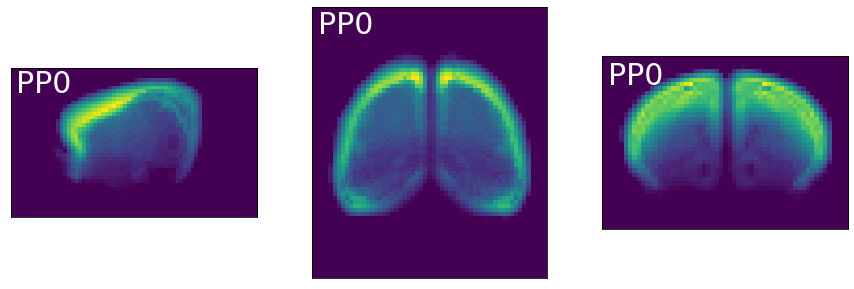

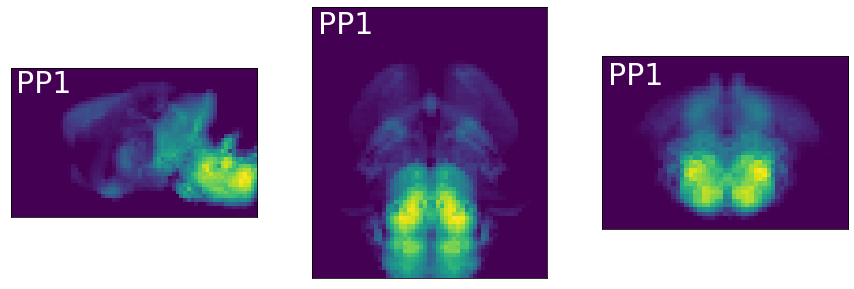

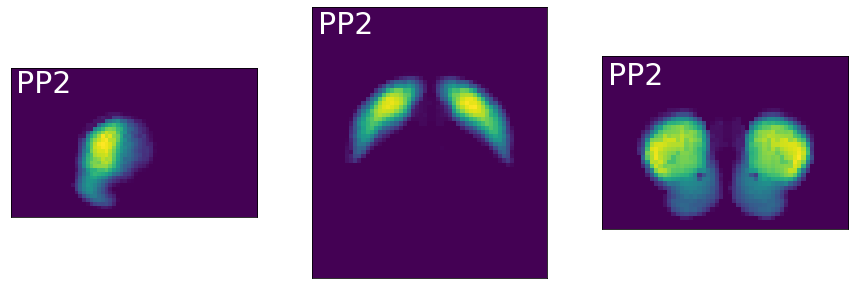

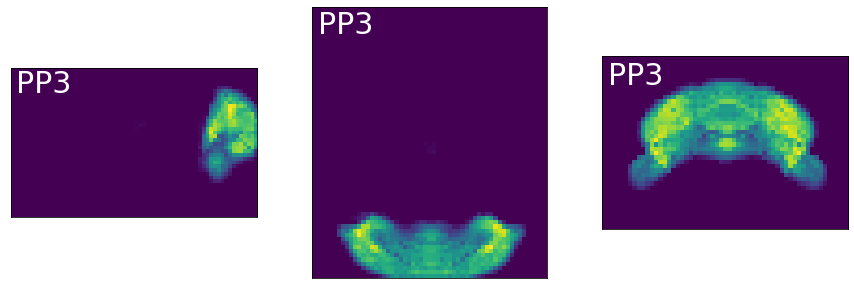

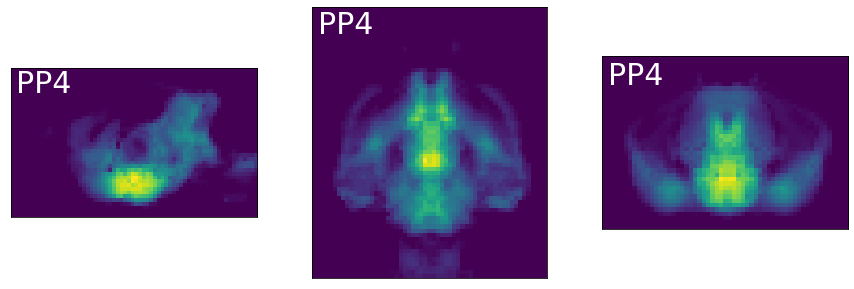

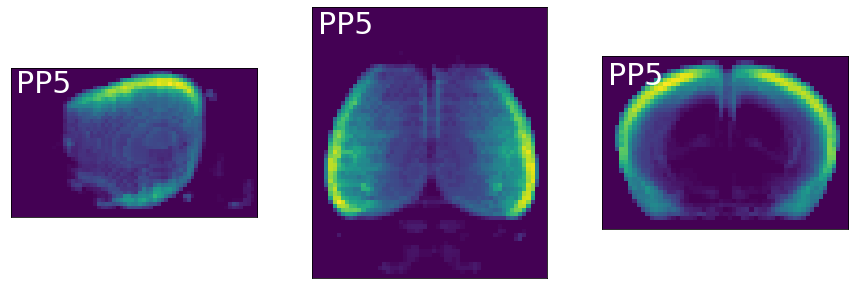

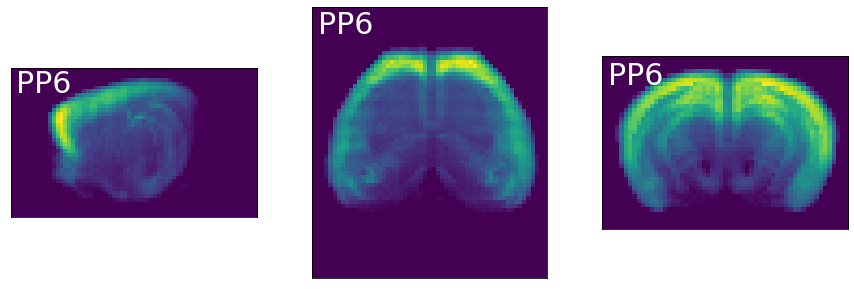

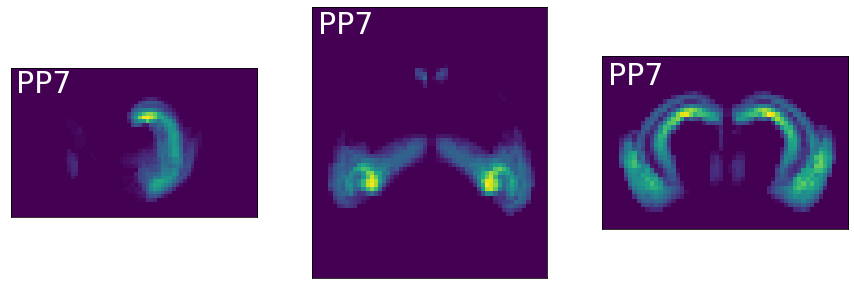

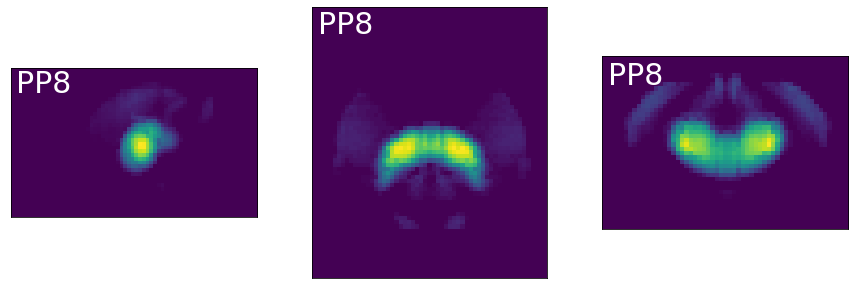

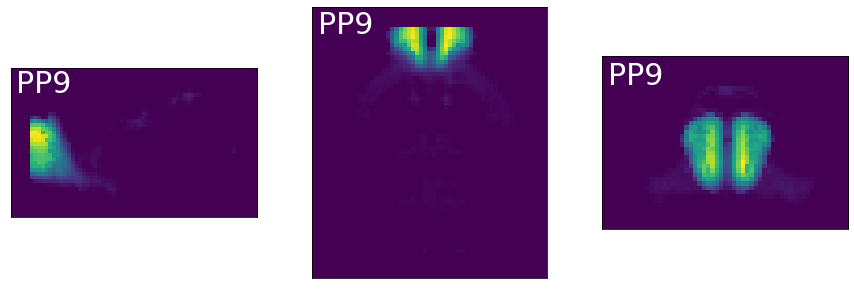

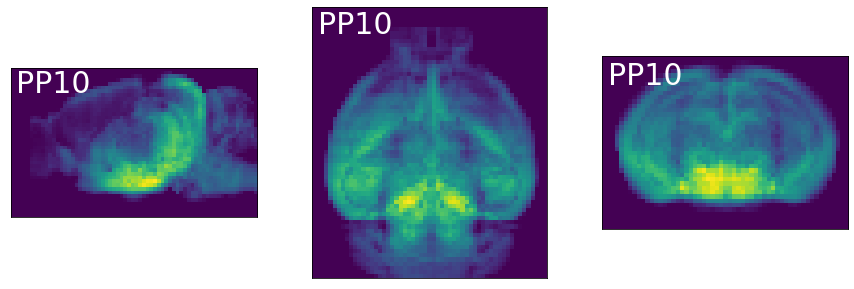

In [6]:
# visualize the PPs
for i in range(11):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    a.imshow(np.mean(PPs_3d[i, :, :, :], 2).T)
    b.imshow(np.mean(PPs_3d[i, :, :, :], 1))
    c.imshow(np.mean(PPs_3d[i, :, :, :], 0))
    a.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    b.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    c.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    b.axes.get_xaxis().set_visible(False)
    b.axes.get_yaxis().set_visible(False)
    c.axes.get_xaxis().set_visible(False)
    c.axes.get_yaxis().set_visible(False)

## 3. Stability analysis

Source: S. Wu, A. Joseph, A. S. Hammonds, S. E. Celniker, B. Yu, and E. Frise, “Stability-driven nonnegative matrix factorization to interpret spatial gene expression and build local gene networks,” Proc. Natl. Acad. Sci., vol. 113, no. 16, Art. no. 15, 2016.

Below is a toy example of this, where we run B=2 simulations for K values (# of PPs) of 10, 11, and 12. For osNMF analysis, we set B=100 and K is the set of integers between 5 and 50.

In [7]:
# Run B=5 simulations for K=[10,11,12]

# Set key variables
K1=10        # sets lower bound (including itself) of PPs
K2=12       # sets upper bound (including itself) of PPs 
B=2        # sets number of replicates
start=0        # start number for naming replicates
folder_path = '../output/instability_runs'

# Set intermediate variables
numPatterns = np.arange(K1, K2+1)
name_DG="DG_PP"
shape_flat = filtered_data.shape[1]

# Run DG and PCA _num_set times to generate _num_set PPs
for k in range(len(numPatterns)):
    K = numPatterns[k]

    # set new directory for K
    path = folder_path + '/K=' + str(K)
    try:
        os.makedirs(path)
    except OSError:
        if not (os.path.isdir(path)):
            raise

    # prep for runs
    print("Working on K = {}...".format(K))
    
    for b in range(B):

        # Bootstrap data and use same bootstrap input for osNMF
        np.random.seed(b)
        X = np.maximum(filtered_data,0)
        n_samples = X.shape[0]
        bootstrap_X = X[np.random.choice(
            n_samples,
            n_samples,
            replace=True)]

        # run and save PP replicates
        nmf = sklearn_nmf(n_components=K,
                          l1_ratio=1,
                          alpha = 0,
                          random_state=1) # random state=1 for reproducibility
        nmf.fit(bootstrap_X) # fit model with bootstrapped data
        PPs_tmp = nmf.components_
        np.savez(path + '/DG_PP_' + str(b+start),PPs_tmp=PPs_tmp)
        
# Run instability
print("Run instability for osNMF:")
instability_DG, instability_std_DG, distMat_DG = instability(_folder_path=folder_path,
                                                             _k1=K1,
                                                             _k2=K2,
                                                             _numReplicates=B,
                                                             _n_features=shape_flat,
                                                             _name=name_DG)

print("\n DG instability values:", instability_DG)

Working on K = 10...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Working on K = 11...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Working on K = 12...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Run instability for DecGene:
Calculating instability for 10
Calculating instability for 11
Calculating instability for 12

 DG instability values: {10: 0.10519985805866987, 11: 0.03894958850099762, 12: 0.06235968191165945}


/Users/robcahill/Desktop/Abbasi_Lab/DecGene_ABA/DecGene_git/DecGene/decgene/stability.py:141: RuntimeWarning: invalid value encountered in double_scalars
  instability_std[k] = (np.sum(distMat ** 2)
/Users/robcahill/Desktop/Abbasi_Lab/DecGene_ABA/DecGene_git/DecGene/decgene/stability.py:141: RuntimeWarning: invalid value encountered in double_scalars
  instability_std[k] = (np.sum(distMat ** 2)
/Users/robcahill/Desktop/Abbasi_Lab/DecGene_ABA/DecGene_git/DecGene/decgene/stability.py:141: RuntimeWarning: invalid value encountered in double_scalars
  instability_std[k] = (np.sum(distMat ** 2)


## 4. 3D visualization of PPs

We use Napari view to visualize PPs.

In [8]:
# Function to visualize PPs using Napari
def create_3D_visualization(_PPs):

    # Create Napari viewer
    viewer = napari.Viewer()

    # Add PPs to viewer
    i = 0
    for i in range(11):
        NAME="PP: "+ str(i)
        viewer.add_image(_PPs[i], name=NAME, colormap='yellow')
        viewer.layers[NAME].opacity=1
        viewer.layers[NAME].gamma=1   # tried 0.5 and 1 for gamma. chose 1 as best visualization.
        viewer.layers[NAME].colormap='red'     # 'red' for osNMF
        viewer.layers[NAME].blending='additive' 
        viewer.layers[NAME].depiction='volume'
        viewer.layers[NAME].rendering='additive' # note: change to attenuated MLP in viewer and keep slide bar 20% from left side

create_3D_visualization(_PPs=PPs_3d)

## 5. Spatial coherence using Moran's Index

To quantify spatial coherence of PPs, we used the Moran’s Index, frequently referred to as Moran’s I [49]. Moran’s I was originally used in geostatistics and has more recently been used in spatial gene expression literature [25], [50], [51]. Moran’s I ranges in value from –1 to 1. A value close to -1 indicates little spatial organization, similar to a chess board with black and white spots distributed across the board. A value close to 1 indicates a clear spatially distinct pattern, such as if all the black blocks in a chess board were on one side and all white blocks on the other.

Below is an example of calculating the Moran's I for each PP. In the paper, we ran Moran's I across 20 bootstrapped replicated of osNMF-generated PPs.

In [9]:
# Calculate Moran's I from PPs

# Load brain mask
areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
mask = np.max(areas_atlas, axis=0)

# Downsample PPs and mask for easier computability
_downsample=2 # downsampling factor

# Downsample function by removing every nth row in each dimension
PPs_3d_downsampled = PPs_3d.copy()
mask_downsampled = mask.copy()
for d in range(3):
    del_list = []
    for i in range(PPs_3d.shape[d+1]):
        if (i) % _downsample == 0:
            del_list.append(i)
    PPs_3d_downsampled = np.delete(PPs_3d_downsampled, del_list, axis=d+1)
    mask_downsampled = np.delete(mask_downsampled, del_list, axis=d)

# Moran's I
moran = MoranIforPPs(PPs_3d_downsampled, mask_downsampled)
print("Average Moran's I of PPs:", round(np.mean(moran),3))

Average Moran's I of PPs: 0.577


## 6. Identifying putative marker genes from PPs

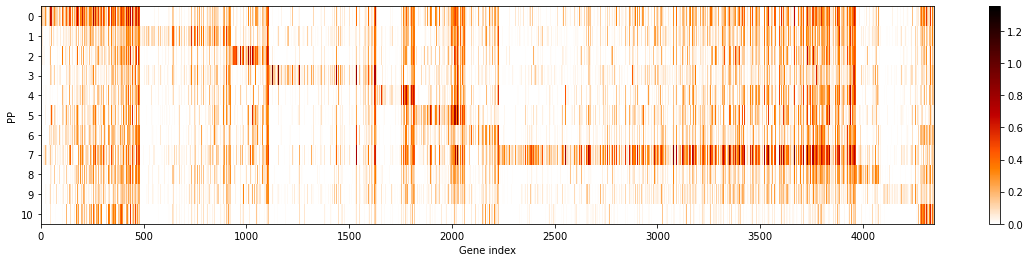

In [10]:
# load original data with gene names
tmp = np.load('../data/mouse_brain_ISH_float32.npz', allow_pickle=True)
data_original = tmp['data']
sections = tmp['sections'].item()
gene_ids = list(sections.keys())
original_shape = data_original.shape

# calculations
gene_inds = []
for pp_ind in range(nmf.components_.shape[0]):
    gene_per_pp = np.where(np.argmax(nmf.components_,axis=0)==pp_ind)[0]
    gene_inds = np.concatenate((gene_inds, gene_per_pp))
gene_inds = gene_inds.astype(int)
D_sorted = nmf.components_[:,gene_inds]

# sort based on amplitude score
gene_inds = []
top_10_genes = np.zeros((coeffs.shape[1],10))

for pp_ind in range(coeffs.shape[1]):
    gene_per_pp = np.where(np.argmax(coeffs,axis=1)==pp_ind)[0]
    amp_metric = coeffs[gene_per_pp,pp_ind]/np.sum(coeffs[gene_per_pp],axis=1)#+np.sum(coeffs[gene_per_pp,pp_ind+1:],axis=1))
    gene_per_pp_arg_sort = np.argsort(amp_metric)[::-1]
    gene_inds = np.concatenate((gene_inds, gene_per_pp[gene_per_pp_arg_sort]))
    top_10_genes[pp_ind,:] = gene_per_pp[gene_per_pp_arg_sort][:10]
gene_inds = gene_inds.astype(int)
coeffs_sorted = coeffs[gene_inds,:]

# display genes by PP (Figure 6A in osNMF paper)
coeffs_ordered = coeffs_sorted.T
plt.figure(figsize=(20,4))
plt.imshow(coeffs_ordered,interpolation='nearest', aspect='auto',cmap='gist_heat_r')
plt.yticks(np.arange(0,11))
plt.ylabel('PP')
plt.xlabel('Gene index')
plt.colorbar()

Top 3 marker genes for PP 1


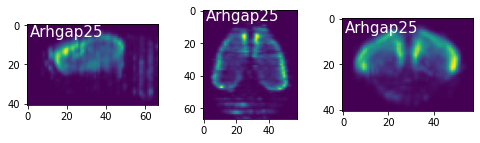

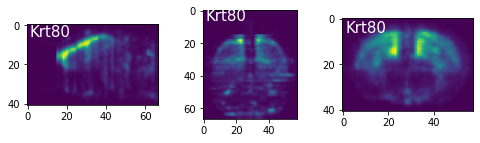

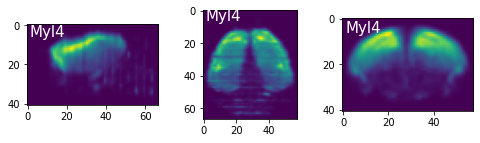

Top 3 marker genes for PP 2


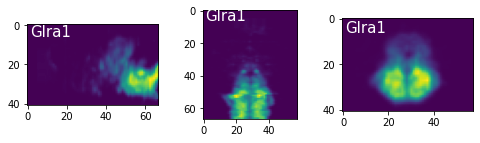

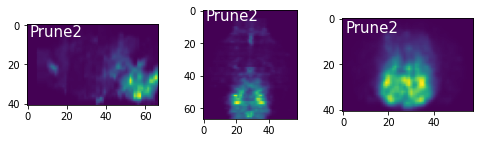

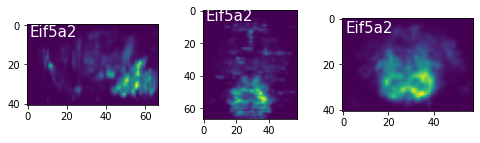

Top 3 marker genes for PP 3


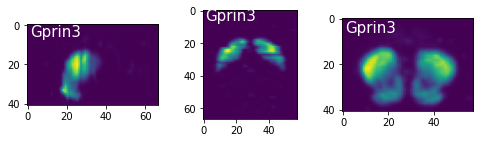

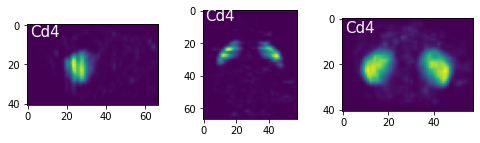

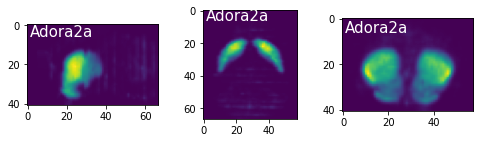

Top 3 marker genes for PP 4


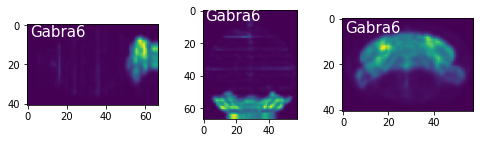

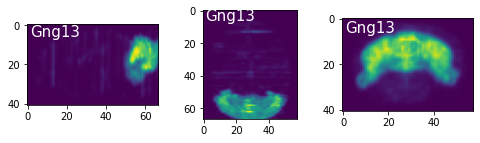

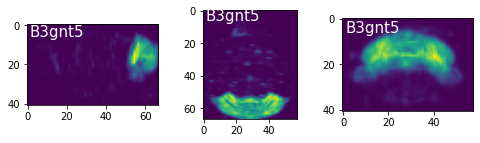

Top 3 marker genes for PP 5


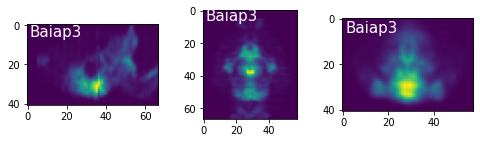

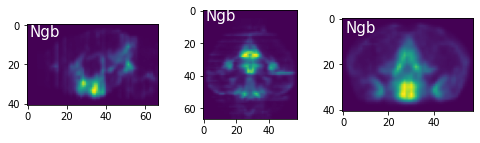

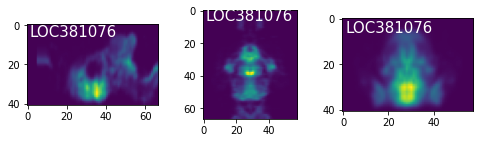

Top 3 marker genes for PP 6


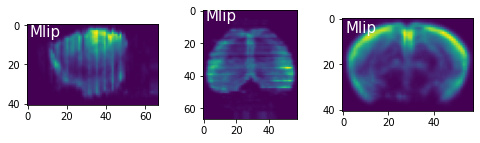

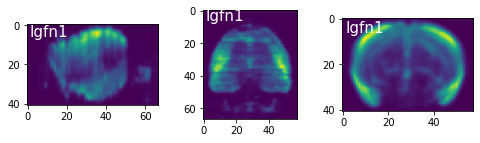

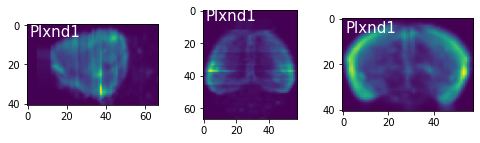

Top 3 marker genes for PP 7


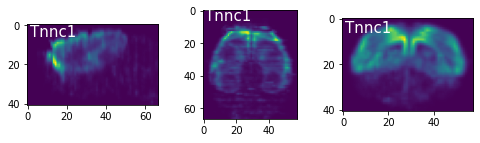

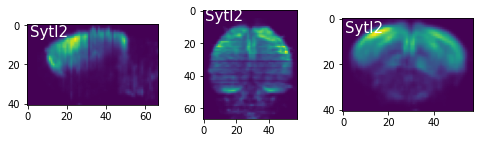

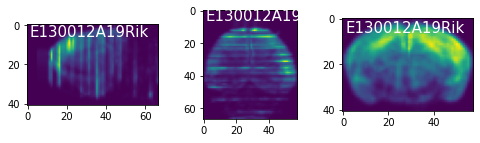

Top 3 marker genes for PP 8


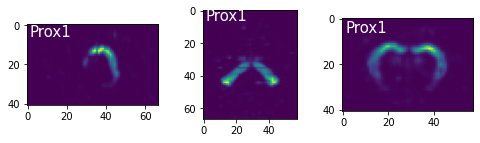

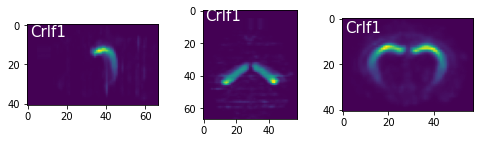

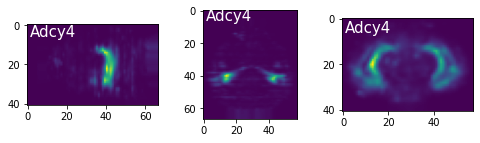

Top 3 marker genes for PP 9


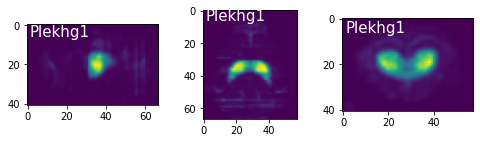

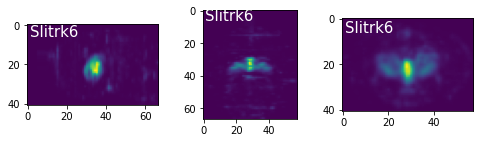

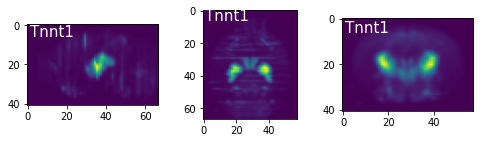

Top 3 marker genes for PP 10


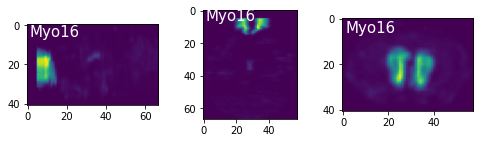

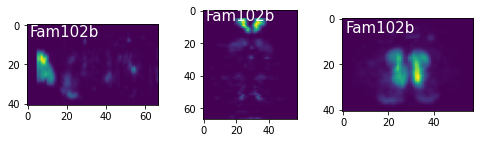

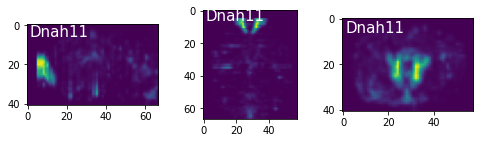

Top 3 marker genes for PP 11


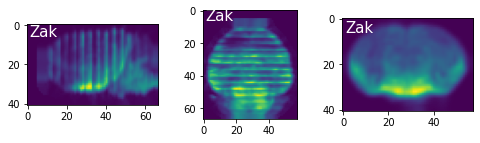

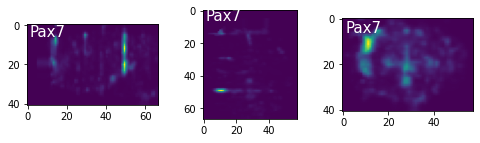

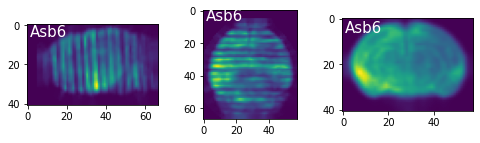

In [11]:
# Visualize top 3 marker genes for each osNMF PP

for pp_ind in range(11):
    print("Top 3 marker genes for PP", str(pp_ind+1))
    for gene_rank in range(3):
        _, (a, b, c) = plt.subplots(1, 3, figsize=(8, 2))
        gene_ind = top_10_genes[pp_ind, gene_rank].astype(int)
        a.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 2).T)
        b.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 1))
        c.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 0))
        a.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=15)
        b.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=15)
        c.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=15)
        plt.show()

## 7. Identify putative local gene interaction networks for each PP

Leveraging osNMF-based PPs in our gene expression datasets, we have implemented the following pipeline to construct the local gene interaction networks: We first identified the top marker genes for each PP by selecting the genes with the top 0.025% highest normalized coefficients for that PP. For these top marker genes of each PP, we computed a similarity score between each pair of genes using the osNMF PP voxel intensities. The similarity score is defined as the correlation coefficient between the osNMF representations of the two genes. We then drew an edge between two genes if their similarity score is among the top 5% of all similarity scores for that gene subset.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


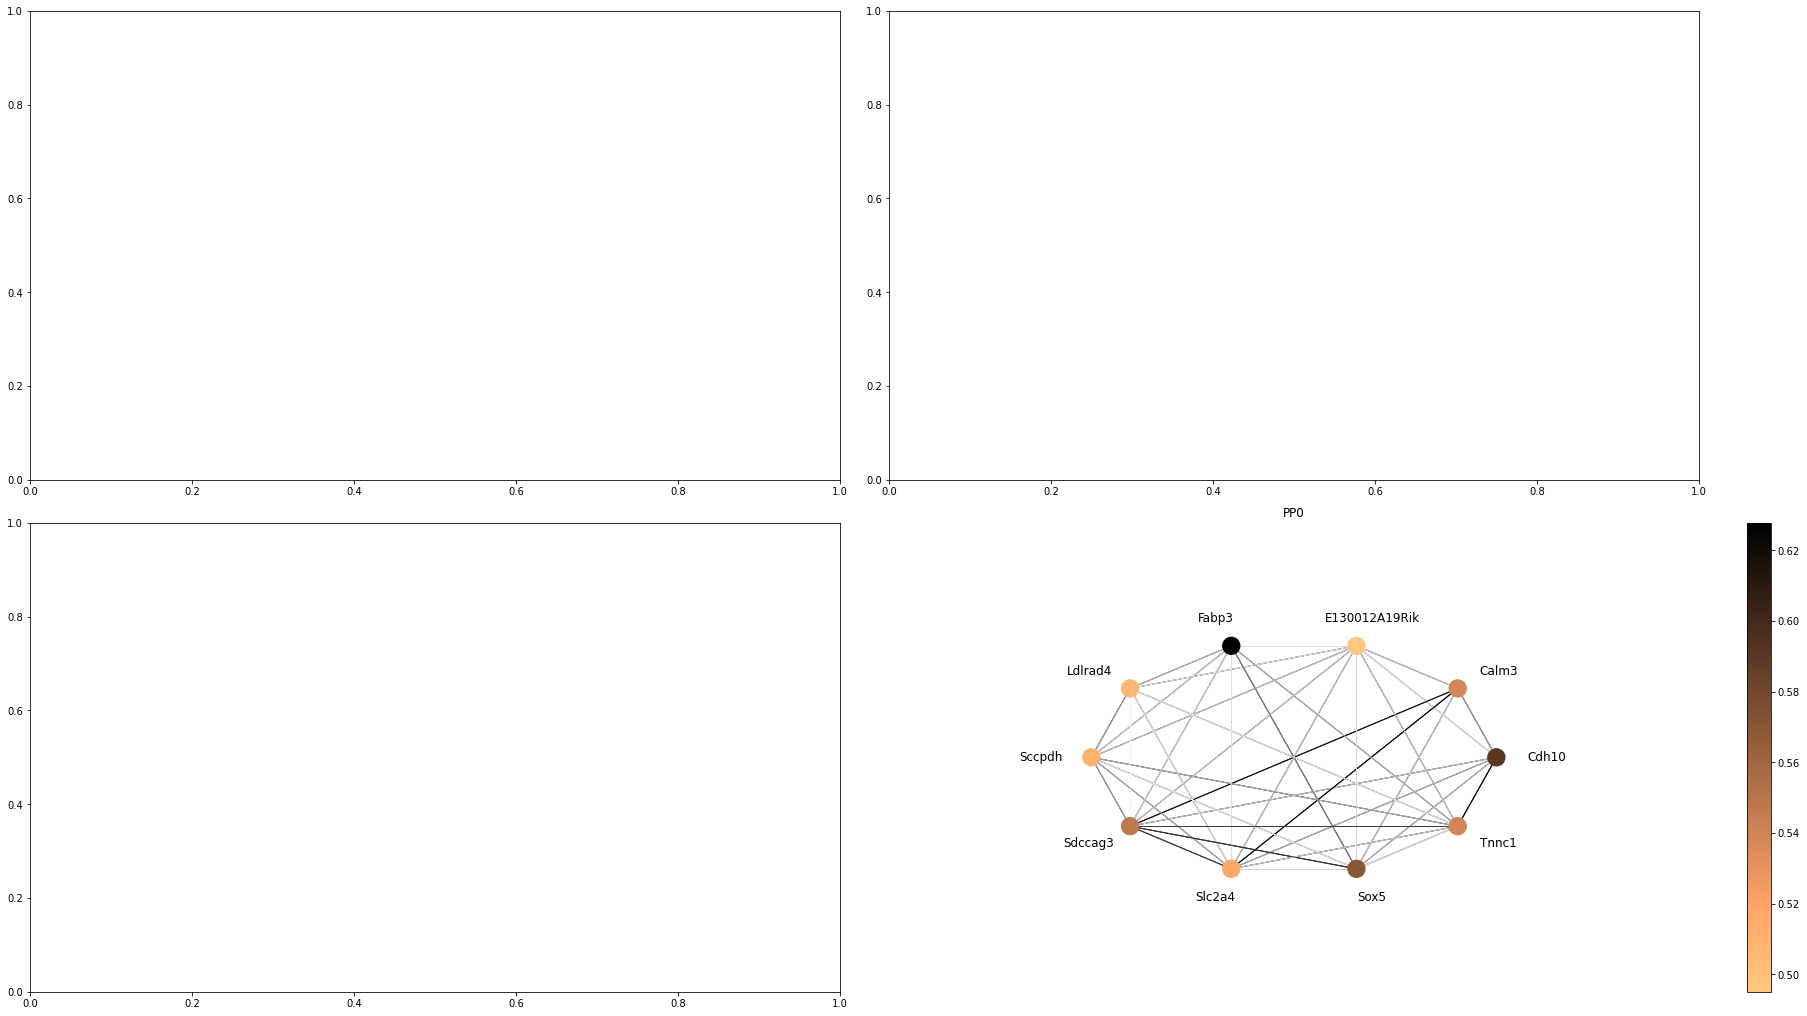

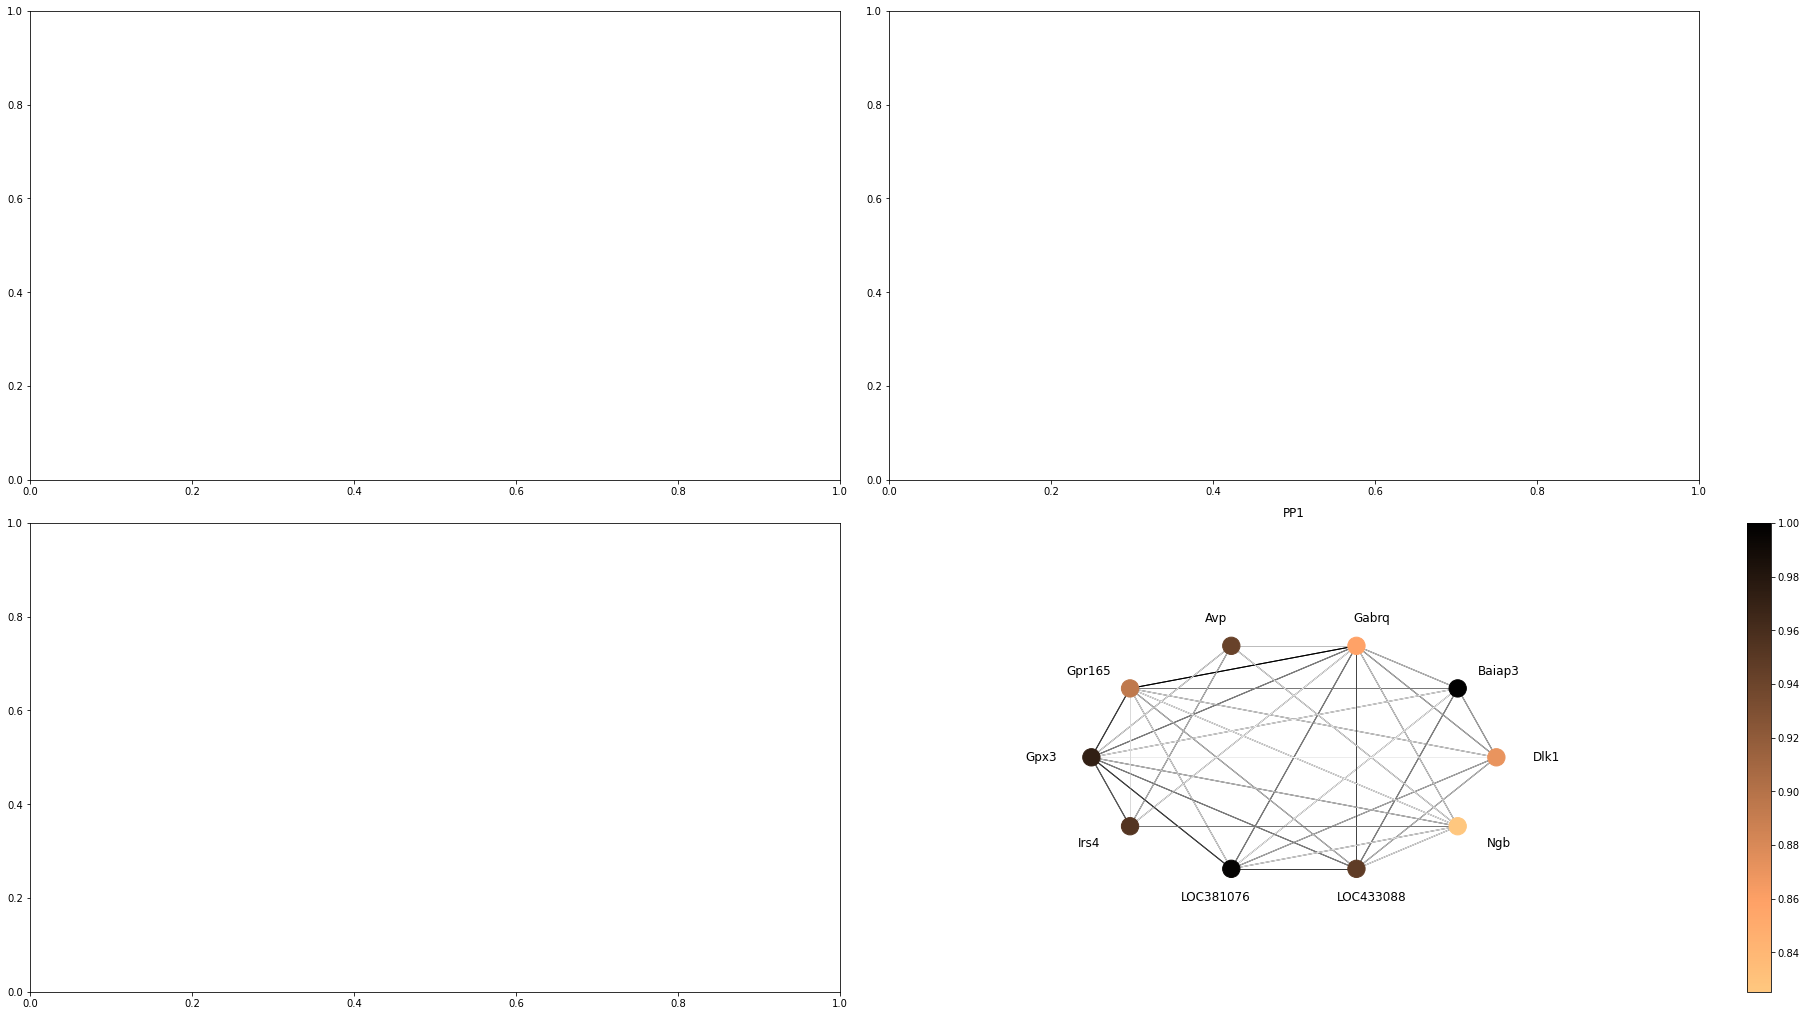

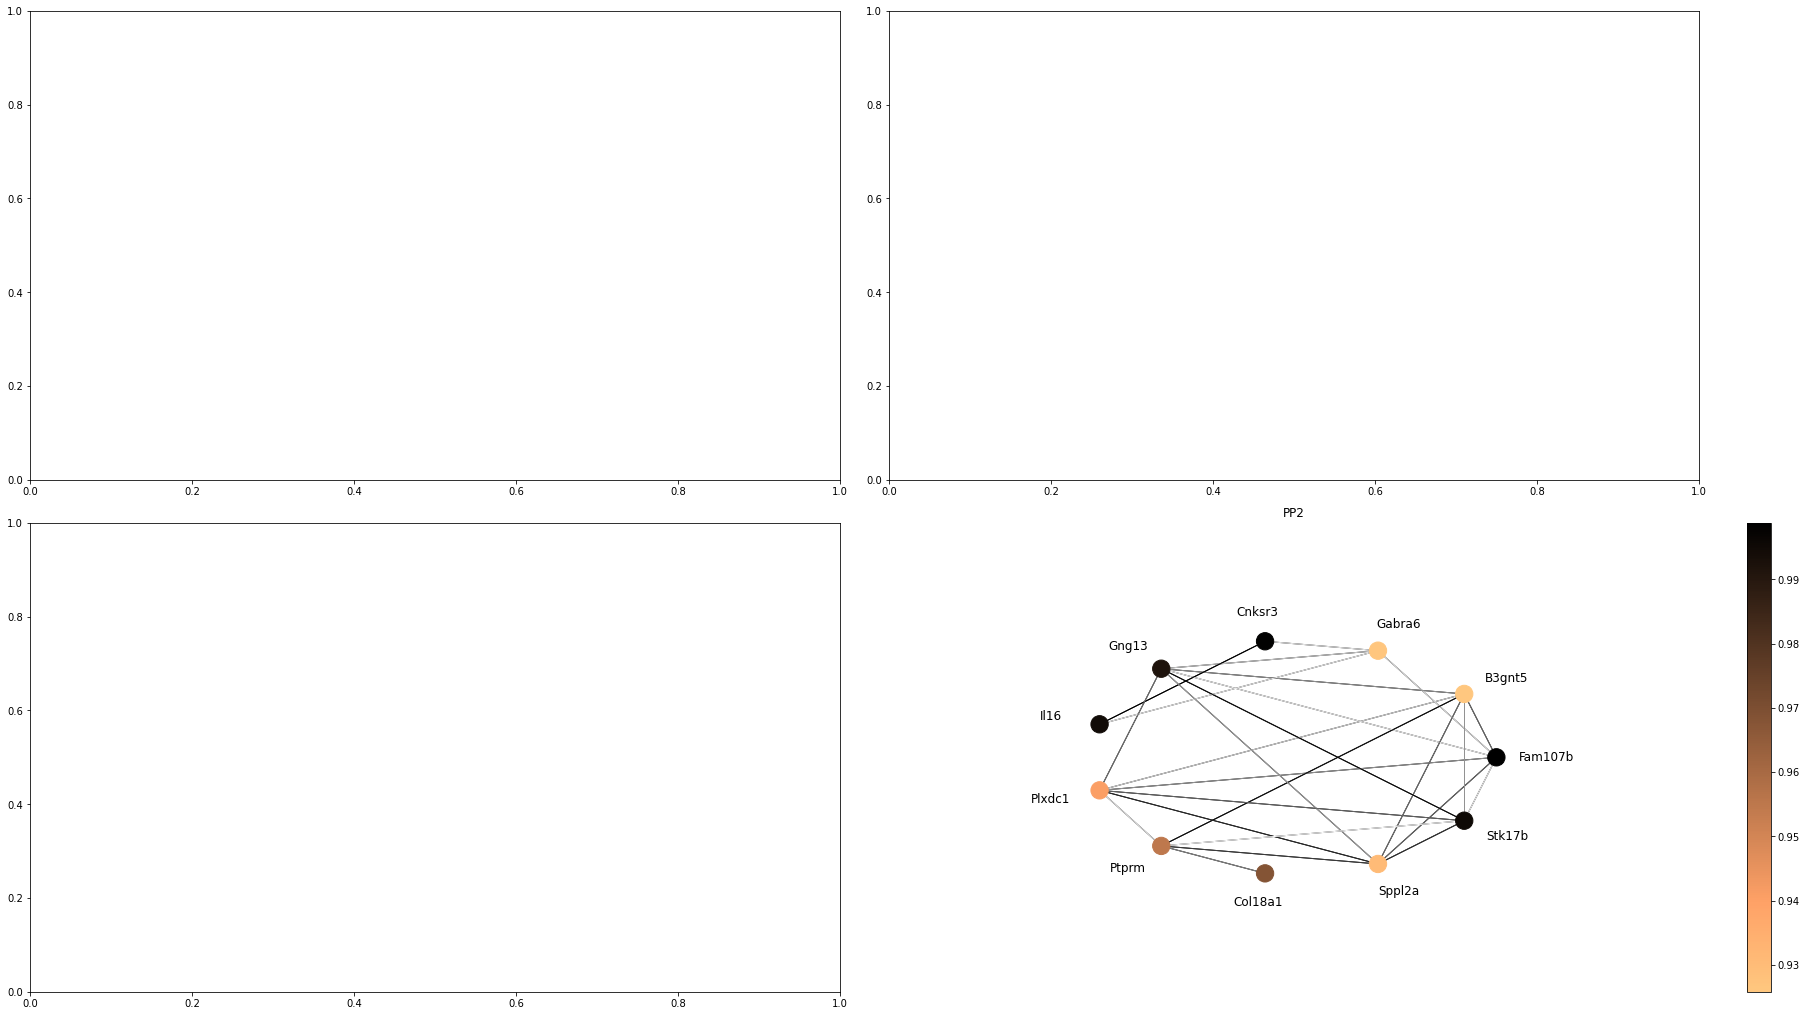

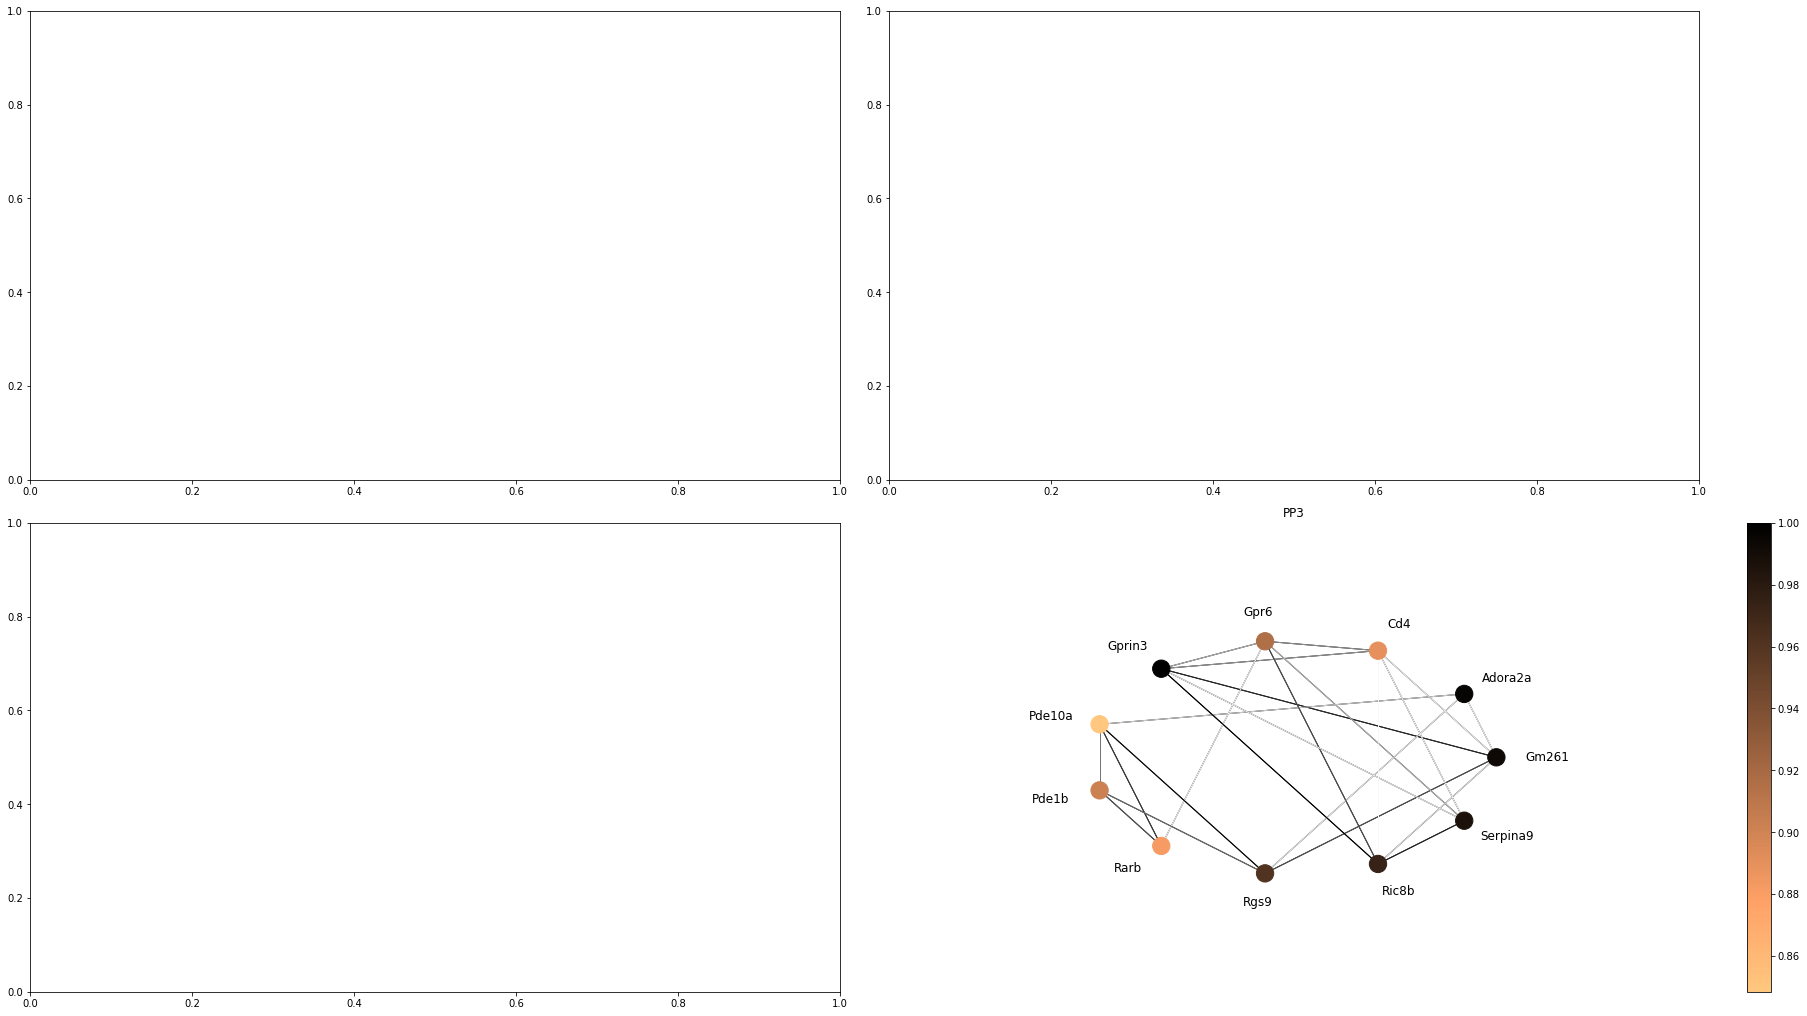

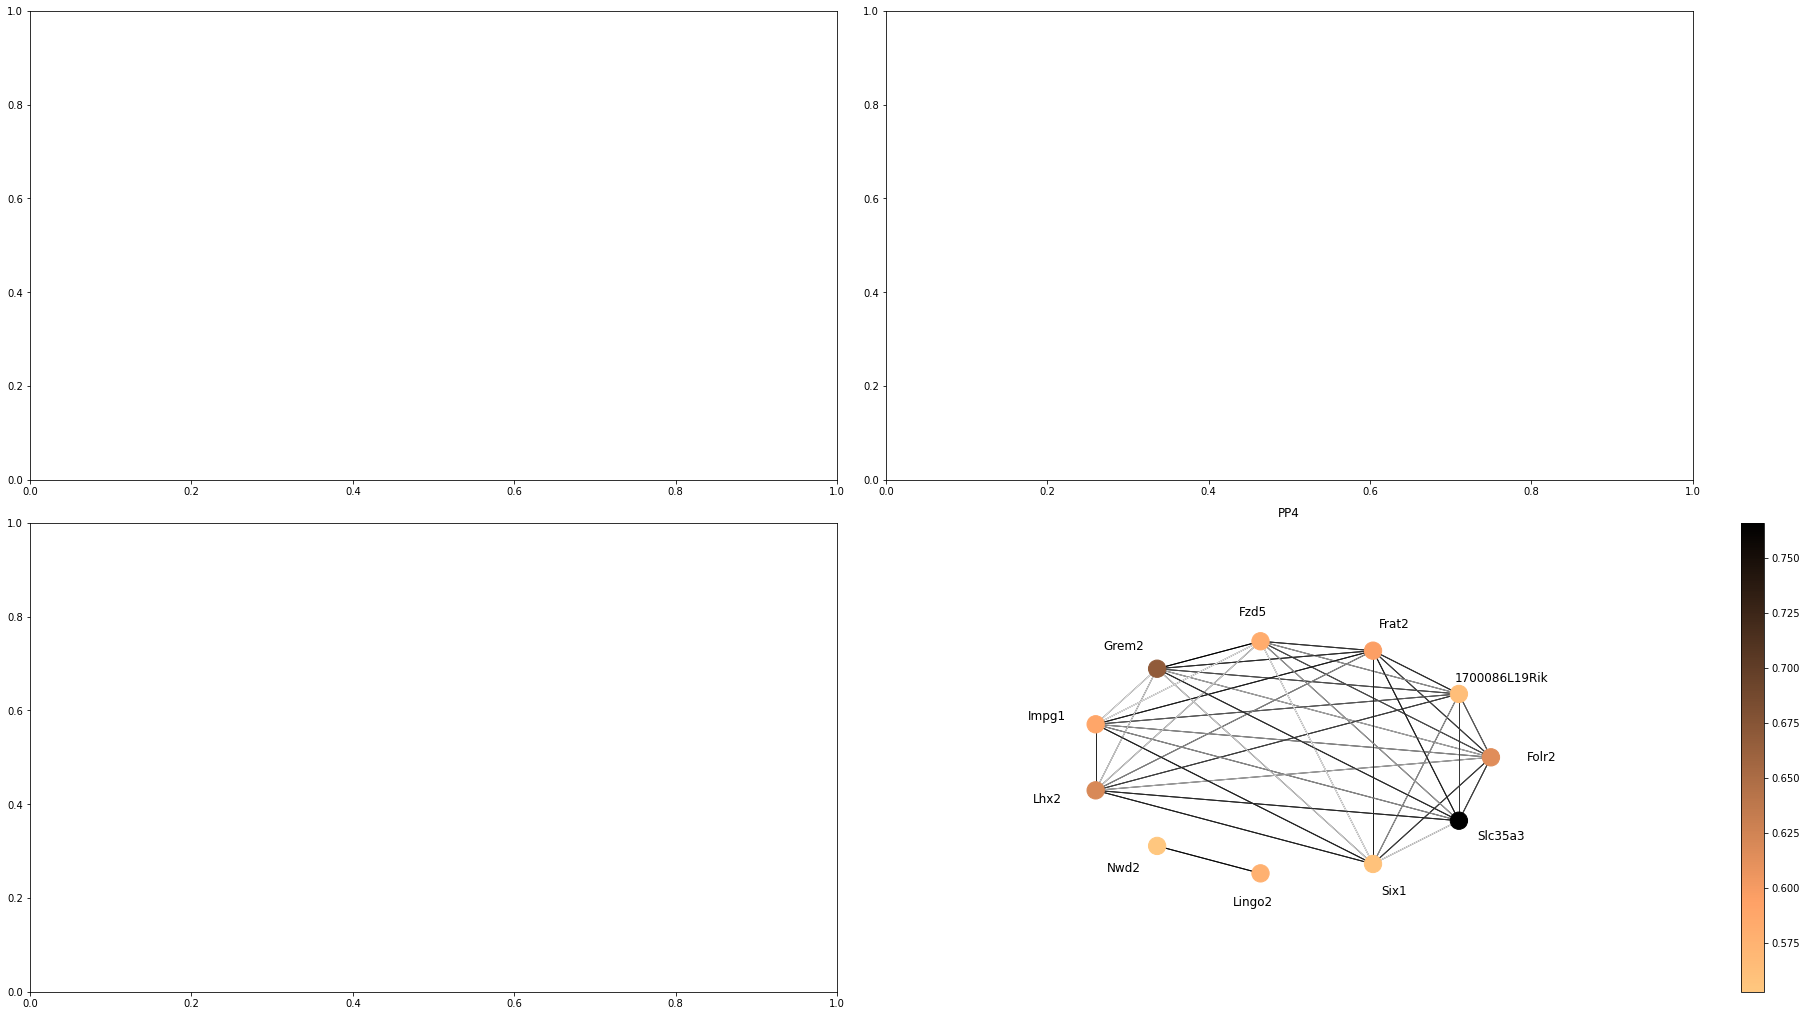

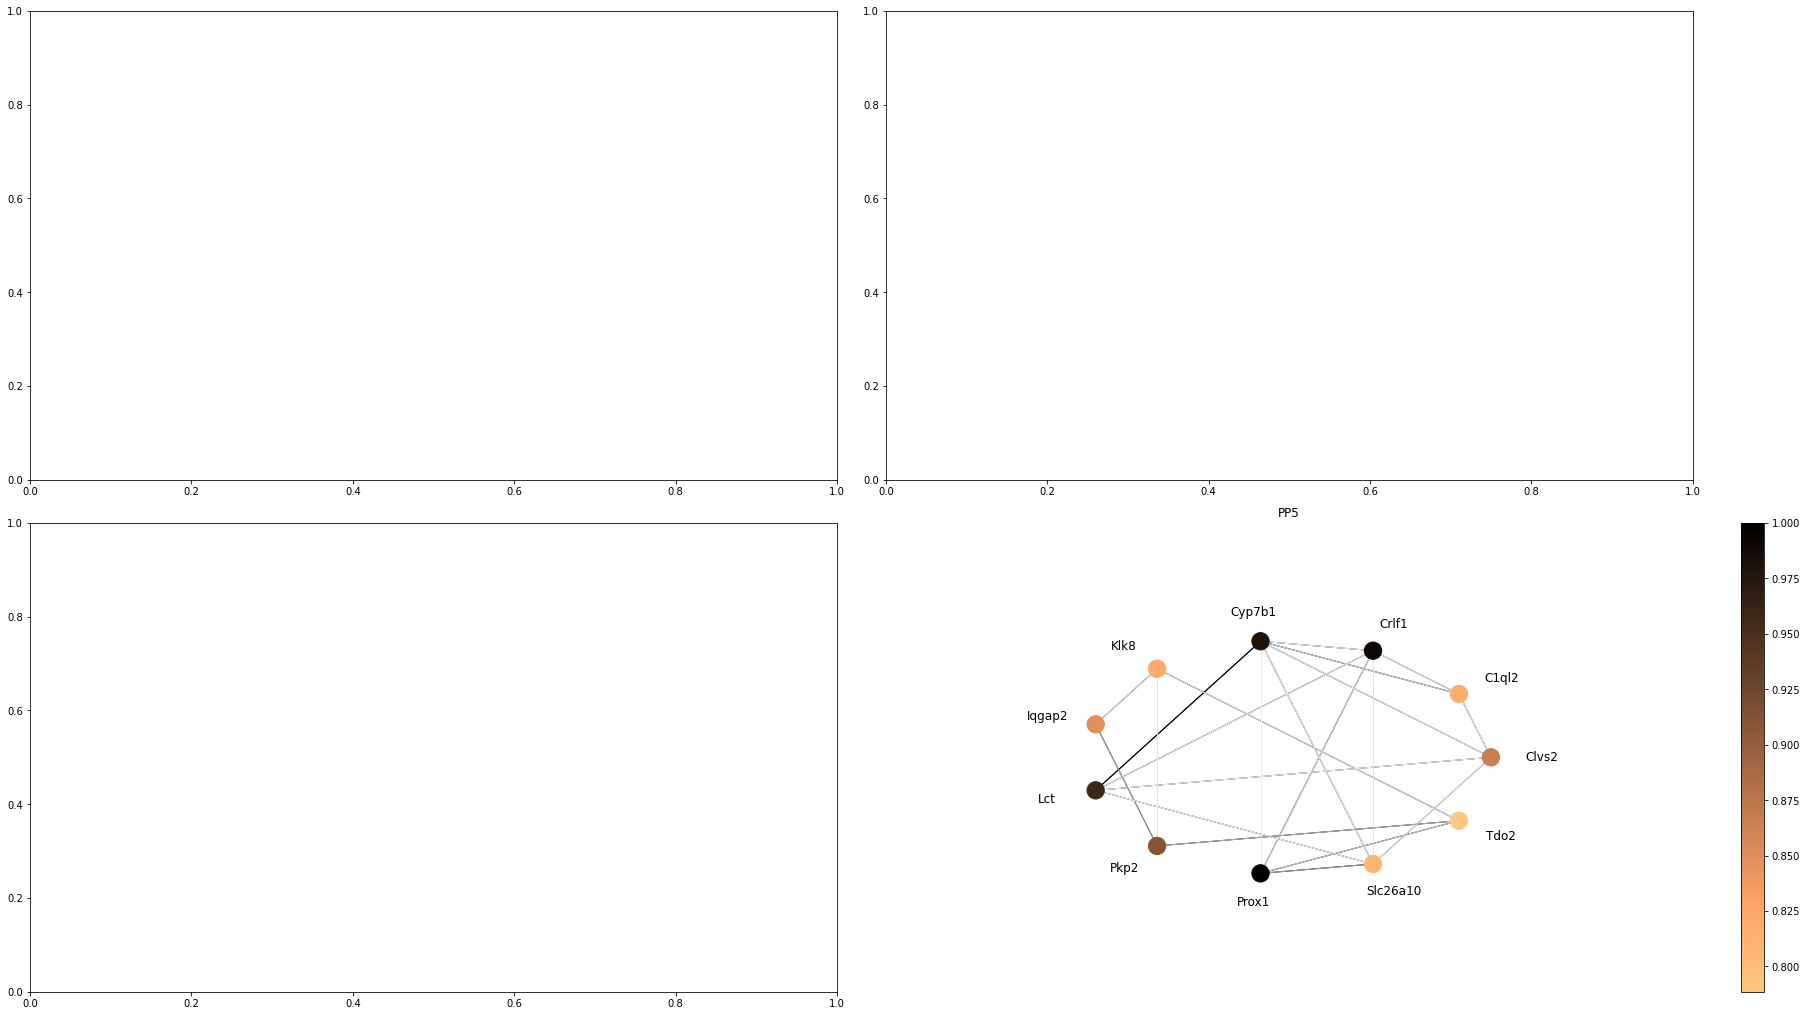

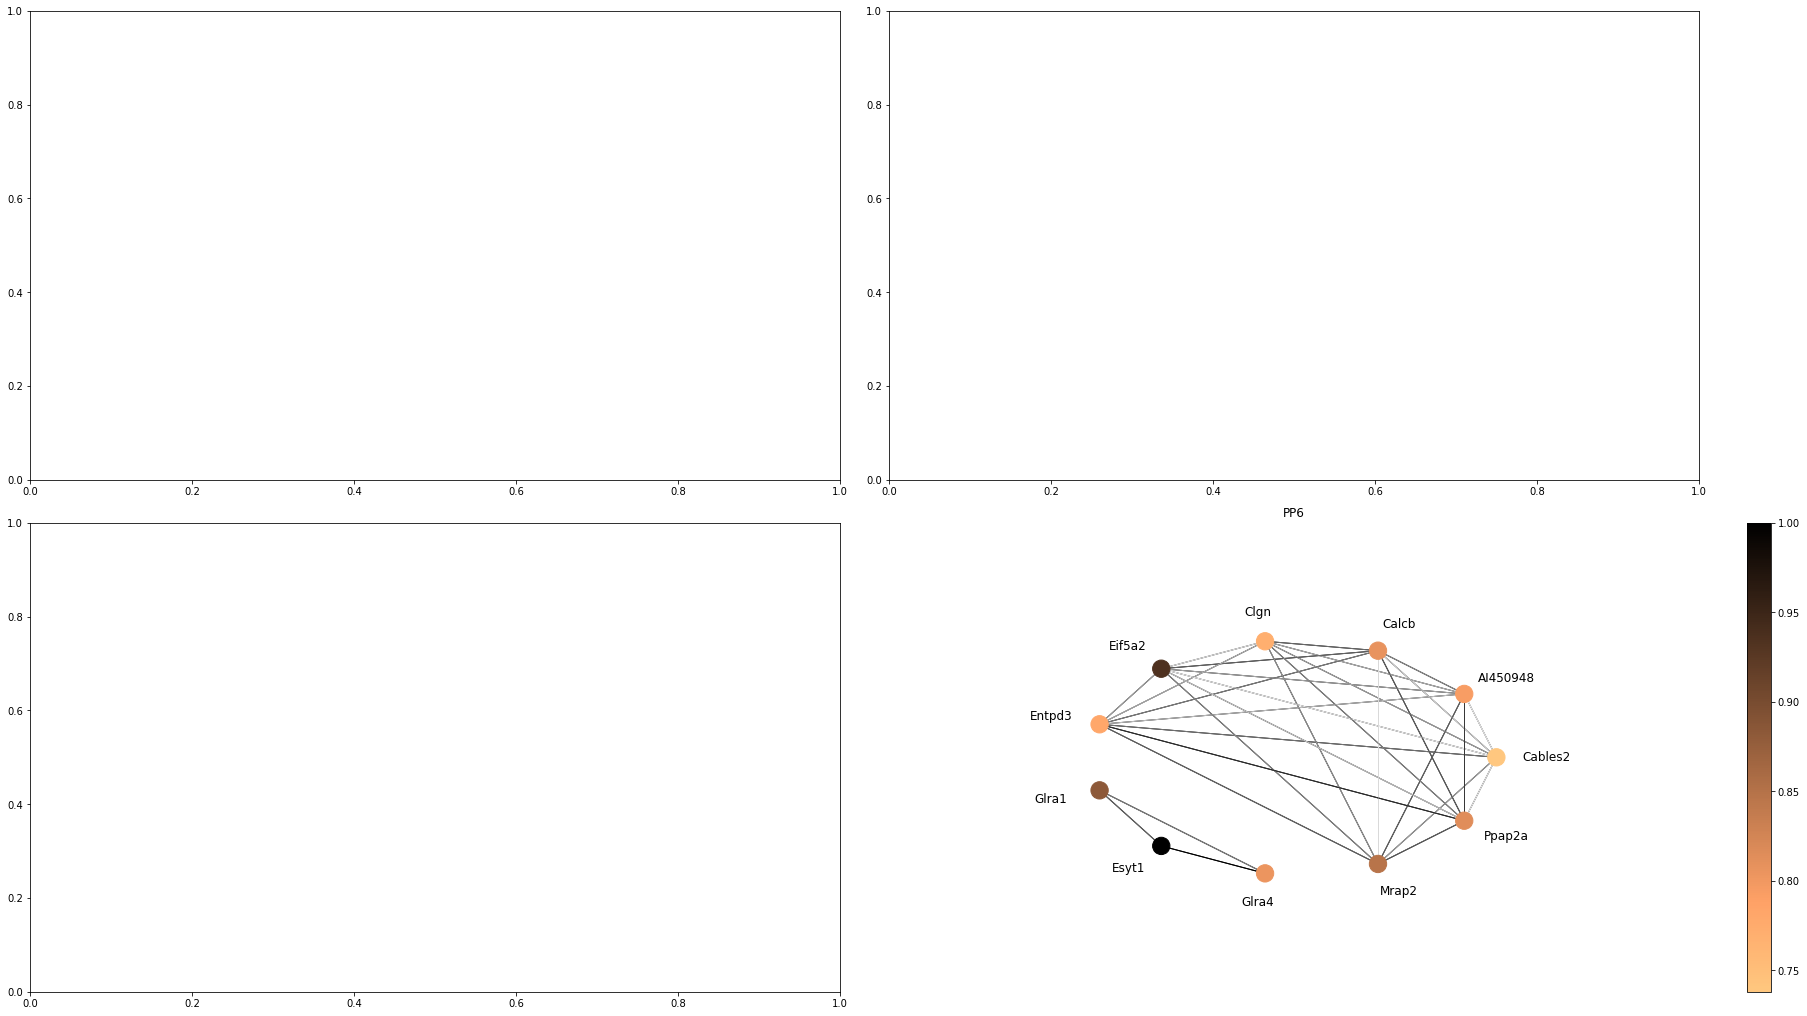

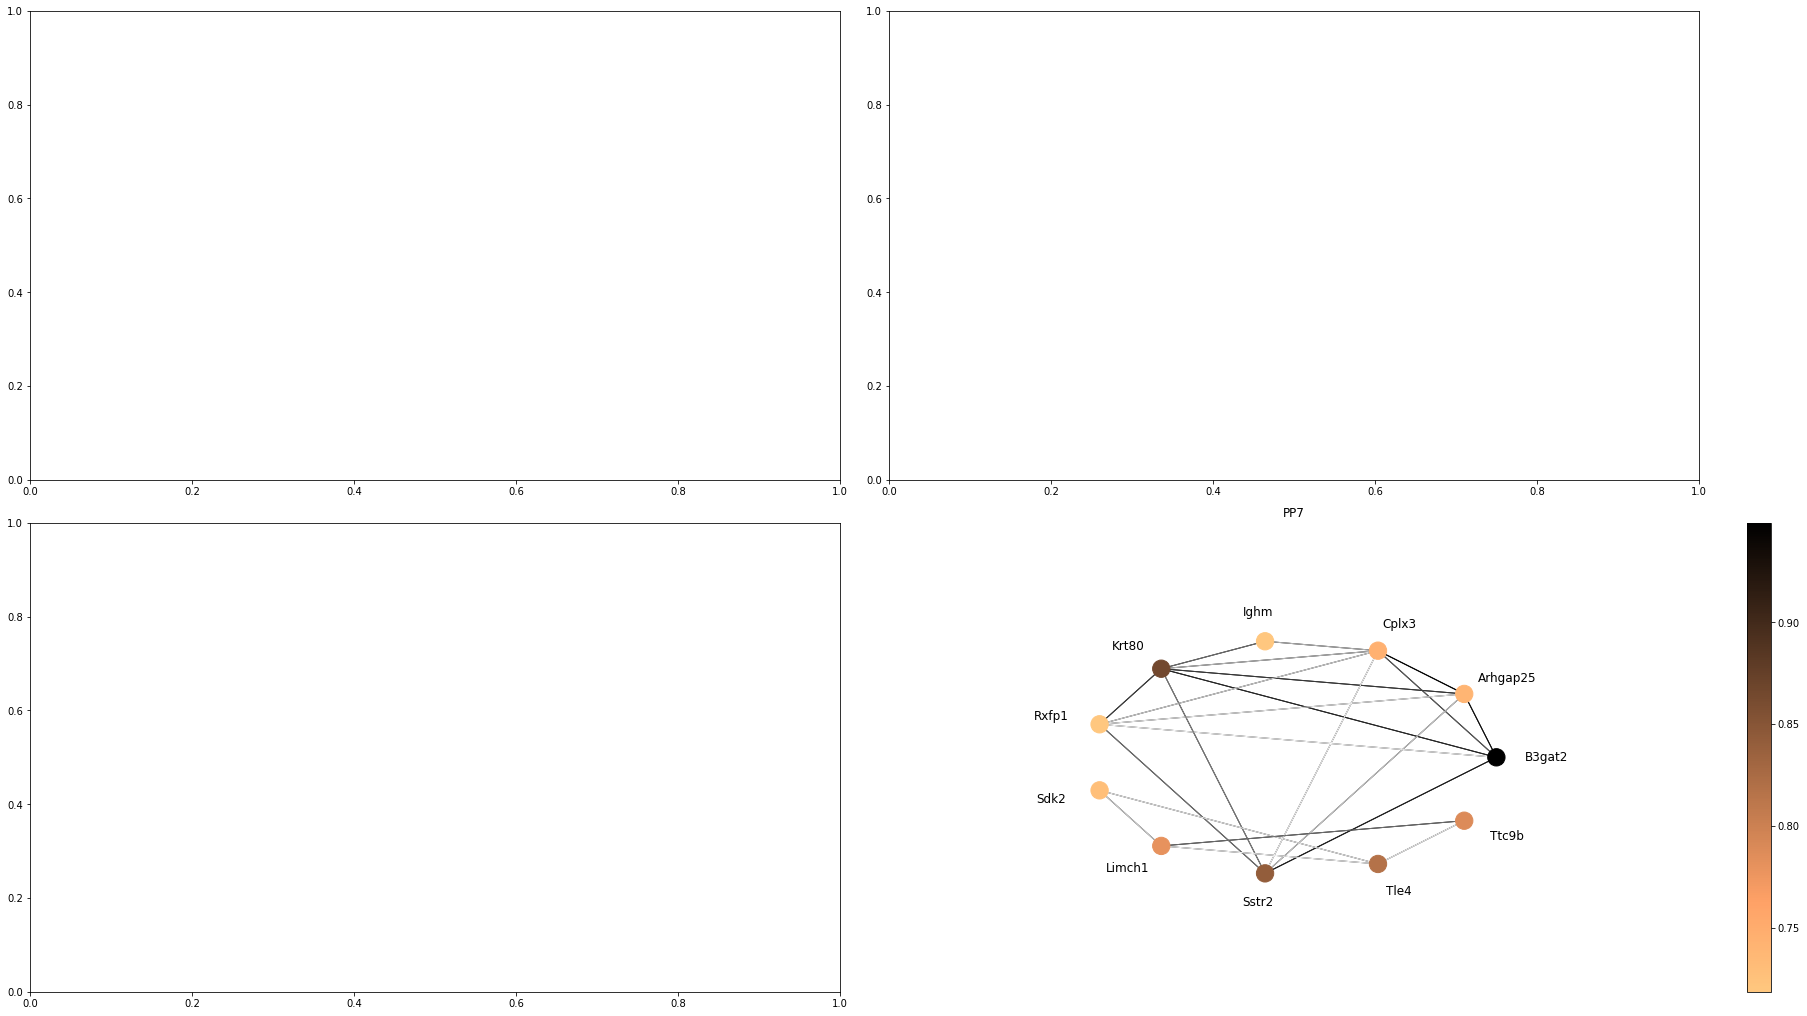

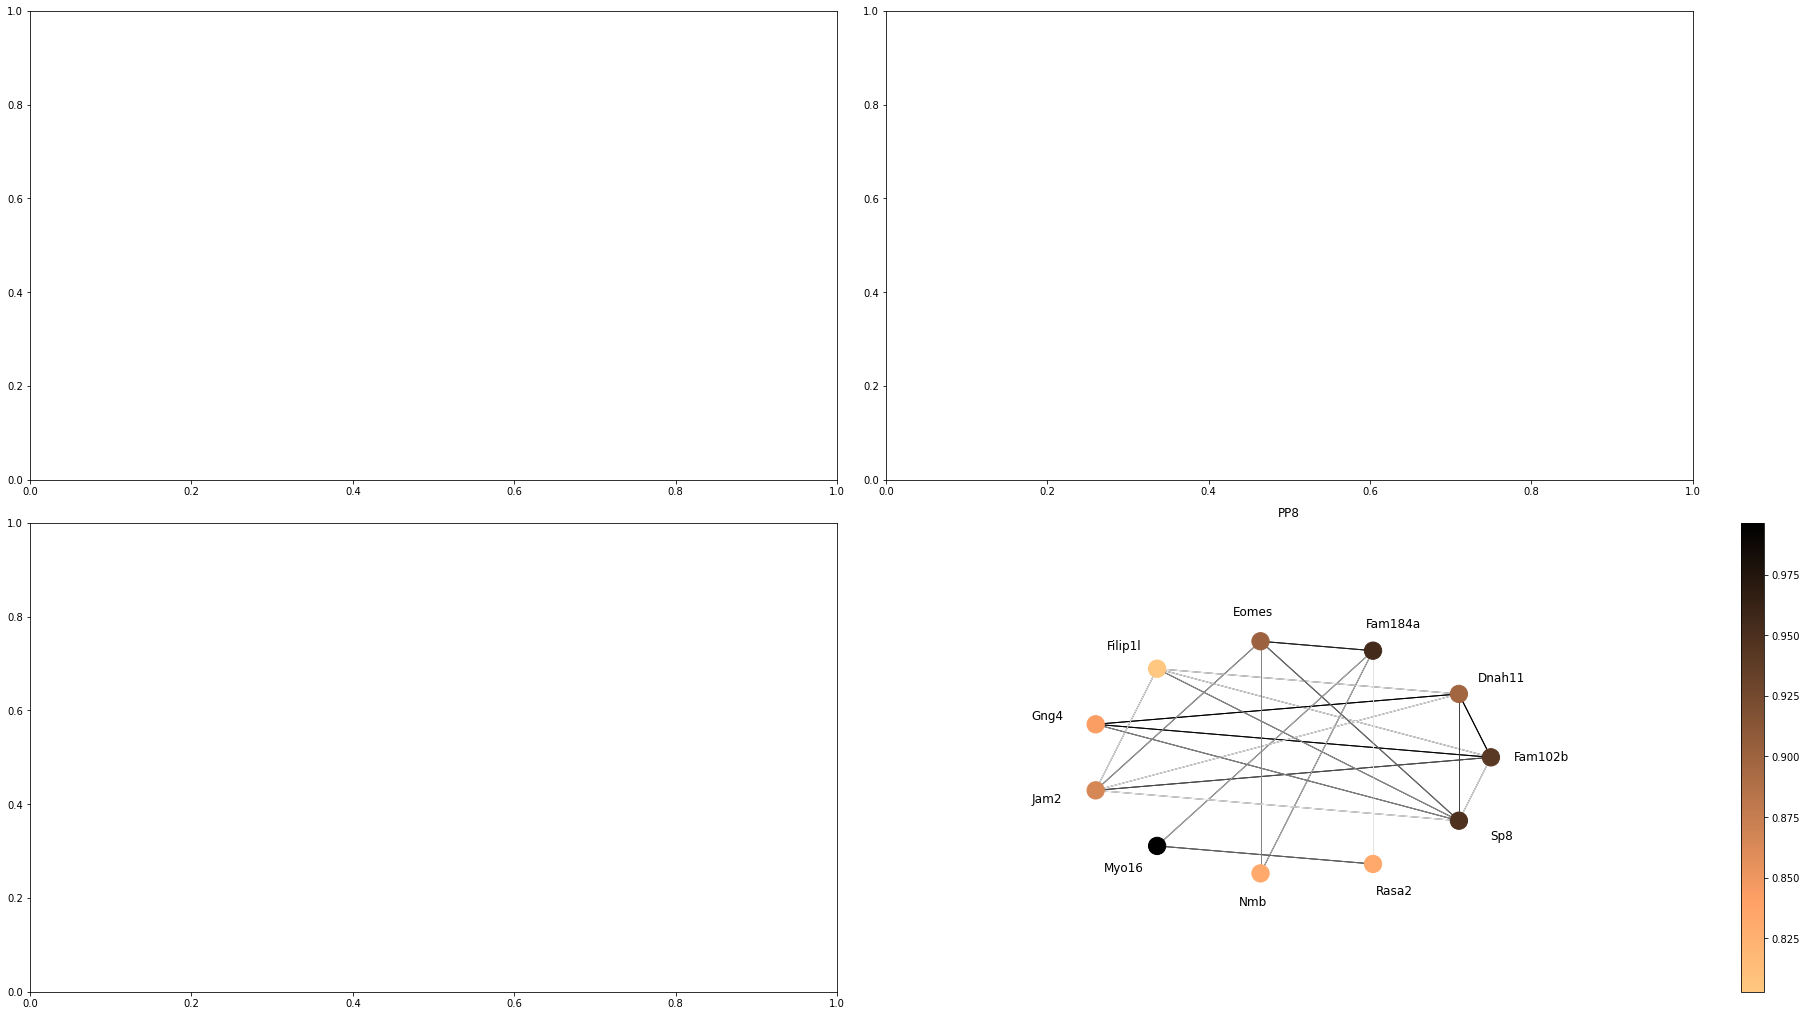

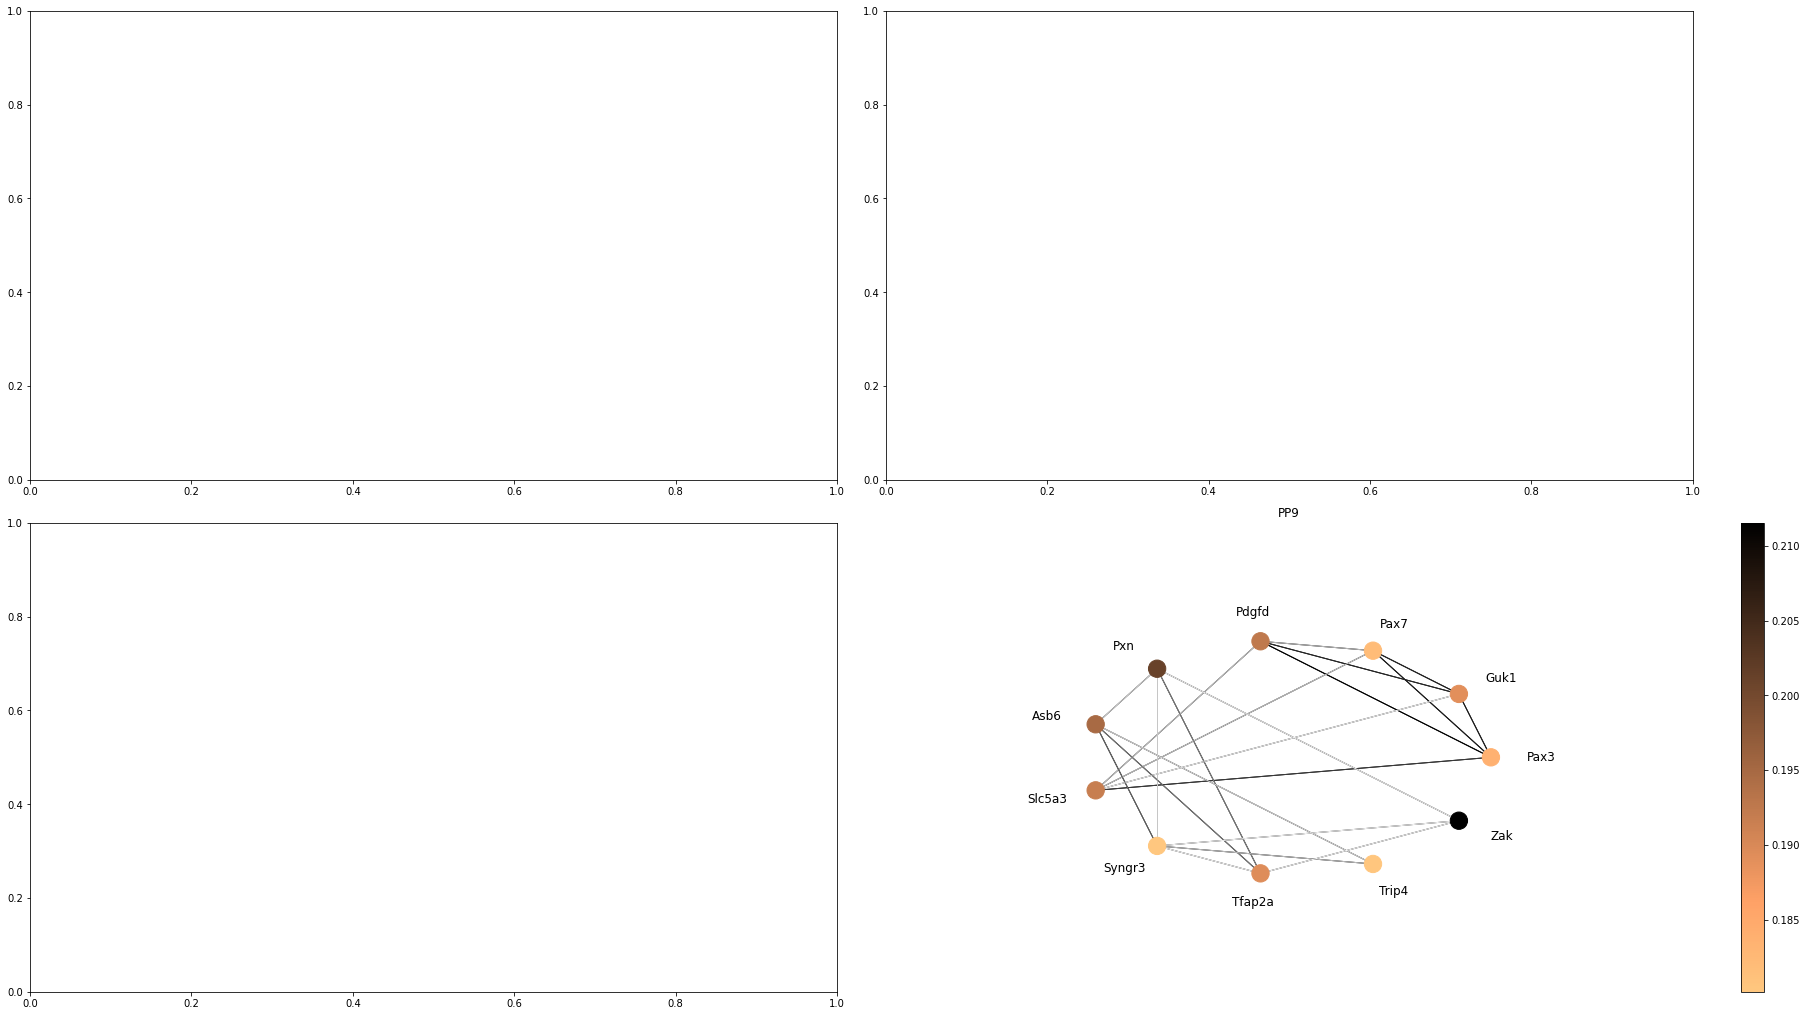

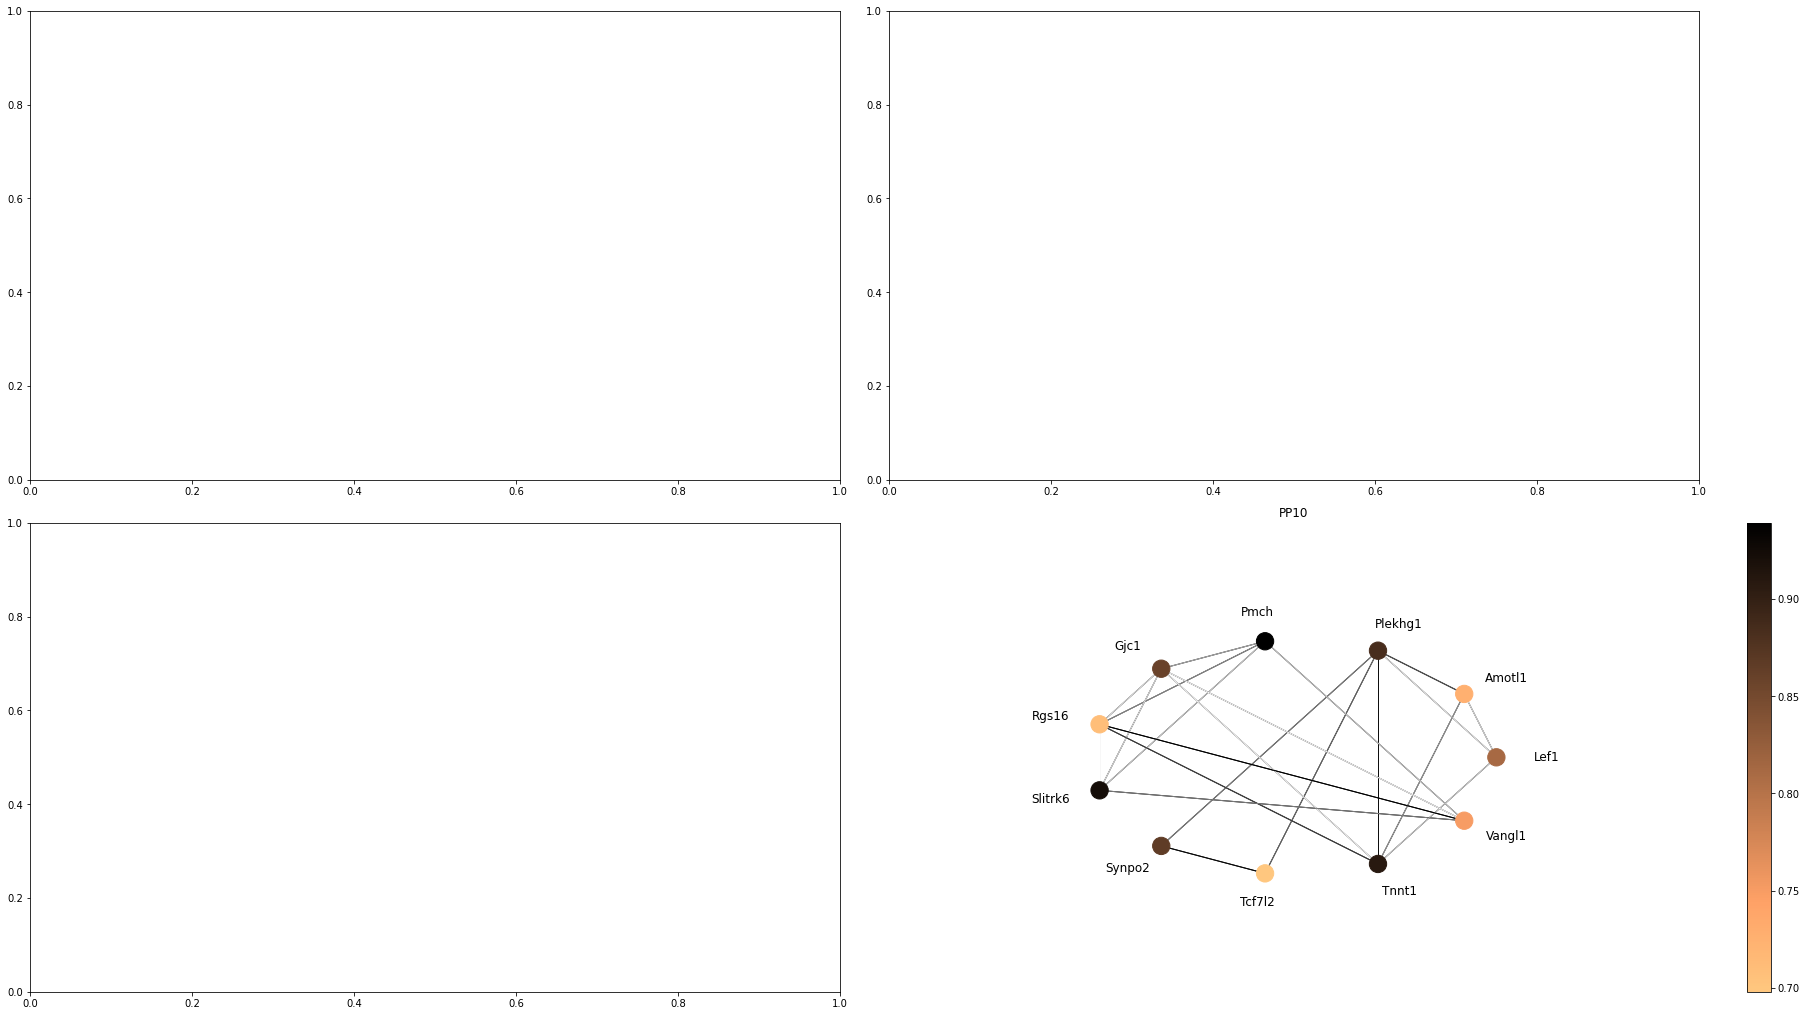

In [12]:
# Identify putative local gene interaction networks for each PP

# Gather gene names
unique_gene_names = np.unique(list(sections.values()))
unique_X = np.zeros((len(unique_gene_names), filtered_data.shape[1]))

for ind, name in enumerate(unique_gene_names):
    gene_ids = np.where([x == name for x in sections.values()])[0]
    #print(gene_ids)
    unique_X[ind,:] = np.mean(filtered_data[gene_ids,:], 0)
    
# solve the coefs
unique_X = unique_X.astype('float32')
unique_coefs = nmf.transform(np.maximum(unique_X, 0))

for i in range(11):
    pps = [i]
    weights = np.mean(nmf.components_[pps], 0)
    selected_gene_ids = filter_genes(unique_coefs, pps, threshold=0.9975) # top 0.25% of genes
    correlations = weighted_correlation(unique_X[selected_gene_ids,:], weights, demean=True)
    selected_gene_names = unique_gene_names[selected_gene_ids]
    colors = (
        unique_coefs[selected_gene_ids, pps[0]]/
        np.sum(unique_coefs[selected_gene_ids], axis=1)
    )
    upper_bound = 0
    adj_matrix = correlations #> upper_bound
    adj_matrix[correlations <= upper_bound] = 0
    show_graph_with_labels(adj_matrix, {ind: name for ind, name in enumerate(selected_gene_names)}, 
                       colors=colors,title="PP{}".format(i))